In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

# set pandas to display not using scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

LOAD_FROM_PICKLE = True
USE_GPU = True

In [2]:
# The kernel needs to be restarted before changing this setting to take effect

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Tensorflow import needs to be after setting the CUDA_VISIBLE_DEVICES

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Activation, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import concatenate
from keras.utils.vis_utils import plot_model

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.10.1
Keras version: 2.10.0
GPU found


In [4]:
if LOAD_FROM_PICKLE:
    with open('../Data/Pickle/loans.pickle', 'rb') as handle:
        df = pickle.load(handle)

    print('Loaded data from pickle')
else:
    # df = pd.read_csv('../Data/Loans/SBAnational.csv', low_memory=False, nrows=100000)
    df = pd.read_csv('../Data/Loans/SBAnational.csv', low_memory=False)

    # drop duplicate rows
    df.drop_duplicates(keep='first', inplace=True)

    # drop rows where BalenceGross is not 0
    # this means that the loan has neither been paid off nor defaulted
    df = df[df['BalanceGross'].str.strip() == '$0.00']

    # drop rows where NAICSCode is 0
    # there are enough missing values in this column that it cannot be reliably imputed
    df = df[df['NAICS'] != 0]

    # divide remaining NAICS codes by 100 to get the first two digits
    # the first two digits of the NAICS code are the industry code
    df['NAICS'] = df['NAICS'].astype(int) // 10000

    # drop rows where NewExist is 0 then
    # subtract 1 from NewExist to make it 0-based
    df = df[df['NewExist'] != 0]
    df['NewExist'] = df['NewExist'] - 1

    # drop columns that are not needed
    df = df.drop(['Bank', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'ChgOffDate', 'BalanceGross', 'ChgOffPrinGr'], axis=1)

    # convert Yes/No and PIF/CHGOFF to 1/0 integers
    # floats is temporary, will be converted to ints later after imputing missing values
    df['RevLineCr'] = df['RevLineCr'].map({'Y': 1, 'N': 0, '1' : 1, '0' : 0})
    df['LowDoc'] = df['LowDoc'].map({'Y': 1, 'N': 0})
    df['MIS_Status'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})

    # remove rows with missing MIS_Status
    # this is the target variable and shouldnt be imputed   
    df = df[df['MIS_Status'].notnull()]

    # for franchiseCode set all values over 1 to 1
    # the value is not important, only if it is a franchise or not
    df['FranchiseCode'] = df['FranchiseCode'].astype(int)
    df['FranchiseCode'] = df['FranchiseCode'].apply(lambda x: 1 if x > 1 else 0)

    # convert dollar amounts to floats
    df['DisbursementGross'] = df['DisbursementGross'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['SBA_Appv'] = df['SBA_Appv'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['ApprovalFY'] = df['ApprovalFY'].astype(int)

    for col in ['City', 'State', 'BankState']:
        df[col] = df[col].str.strip()
        df[col] = df[col].str.upper()

    num_rows = df.shape[0]
    # drop rows with missing values
    # this is about 3% of the data
    df = df.dropna()

    dropped_rows = num_rows - df.shape[0]
    dropped_percent = dropped_rows / num_rows * 100
    print('Dropped {} rows with missing values'.format(dropped_rows))
    print('Dropped {:.2f}% of the data'.format(dropped_percent))

    # convert NewExist, RevLineCr, and LowDoc to int
    df['NewExist'] = df['NewExist'].astype('int')
    df['RevLineCr'] = df['RevLineCr'].astype('int')
    df['LowDoc'] = df['LowDoc'].astype('int')

    # create a new column for if the buisness state is the same as the bank state
    # in the first lab I discovered this had a significant impact on if the loan was paid off or not
    df['BankStateSame'] = df['State'].eq(df['BankState']).astype(int)

    # save data to pickle
    with open('../Data/Pickle/loans.pickle', 'wb') as handle:
        pd.to_pickle(df, handle, protocol=4)

Loaded data from pickle


In [9]:
categorical_headers = ['City', 'State', 'Zip', 'BankState', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'BankStateSame']
numeric_headers = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv', 'SBA_Appv']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672172 entries, 0 to 899161
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               672172 non-null  int64  
 1   State              672172 non-null  int64  
 2   Zip                672172 non-null  int64  
 3   BankState          672172 non-null  int64  
 4   NAICS              672172 non-null  int64  
 5   ApprovalFY         672172 non-null  int64  
 6   Term               672172 non-null  int64  
 7   NoEmp              672172 non-null  int64  
 8   NewExist           672172 non-null  int64  
 9   CreateJob          672172 non-null  int64  
 10  RetainedJob        672172 non-null  int64  
 11  FranchiseCode      672172 non-null  int64  
 12  UrbanRural         672172 non-null  int64  
 13  RevLineCr          672172 non-null  int64  
 14  LowDoc             672172 non-null  int64  
 15  DisbursementGross  672172 non-null  float64
 16  MI

In [11]:
# encode categorical features that are not already encoded
# this needs to be done before splitting the data into train and test sets
# otherwise the test set can have categories that the training set does not have, 
# mainly City and Zip because there are so many unique values
# this also ensures that the same encoding is used for both the training and test sets
# I am aware this may introduce a small amount of data snooping but I think doing it here
# is worth the trade off of not having to stratify the data by the target variable, city, and zip
# the amount of data snooping is minimal as this should produce almost identical encodings

encoders = {}

for col in categorical_headers:
    print(f'Encoding {col}')
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

# test train split
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, stratify=y)

Encoding City
Encoding State
Encoding Zip
Encoding BankState
Encoding NAICS
Encoding NewExist
Encoding FranchiseCode
Encoding UrbanRural
Encoding RevLineCr
Encoding LowDoc
Encoding BankStateSame


In [12]:
ss = StandardScaler()
X_train[numeric_headers] = ss.fit_transform(X_train[numeric_headers].values)
X_test[numeric_headers] = ss.transform(X_test[numeric_headers].values)

# convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values
y_train = y_train.values.astype(np.int32)
y_test = y_test.values.astype(np.int32)

In [ ]:
# Now let's define the architecture for a multi-layer network

# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
# Dense means a fully connected layer, with 10 hidden neurons and a bias term
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

In [ ]:
plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=4096, verbose=1)

# now lets see how well the model performed
yhat_proba = model.predict(X_test) # sigmoid output probabilities
yhat = np.round(yhat_proba) # round to get binary class

print(mt.confusion_matrix(y_test, yhat))
print(mt.classification_report(y_test, yhat))

In [19]:
X_train_cat = X_train[categorical_headers].to_numpy() 
X_test_cat = X_test[categorical_headers].to_numpy()

# and save off the numeric features
X_train_num =  X_train[numeric_headers].to_numpy()
X_test_num = X_test[numeric_headers].to_numpy()

all_branch_outputs = [] # this is where we will keep track of output of each branch

# -----Like previous example, use embeddings from the integer data -----
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    N = len(encoders[categorical_headers[idx]].classes_)
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# -----HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA-----
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=9, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)
# -------------------------------------------------------------------

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

model = Model(inputs=[input_cat,inputs_num], outputs=final_branch)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

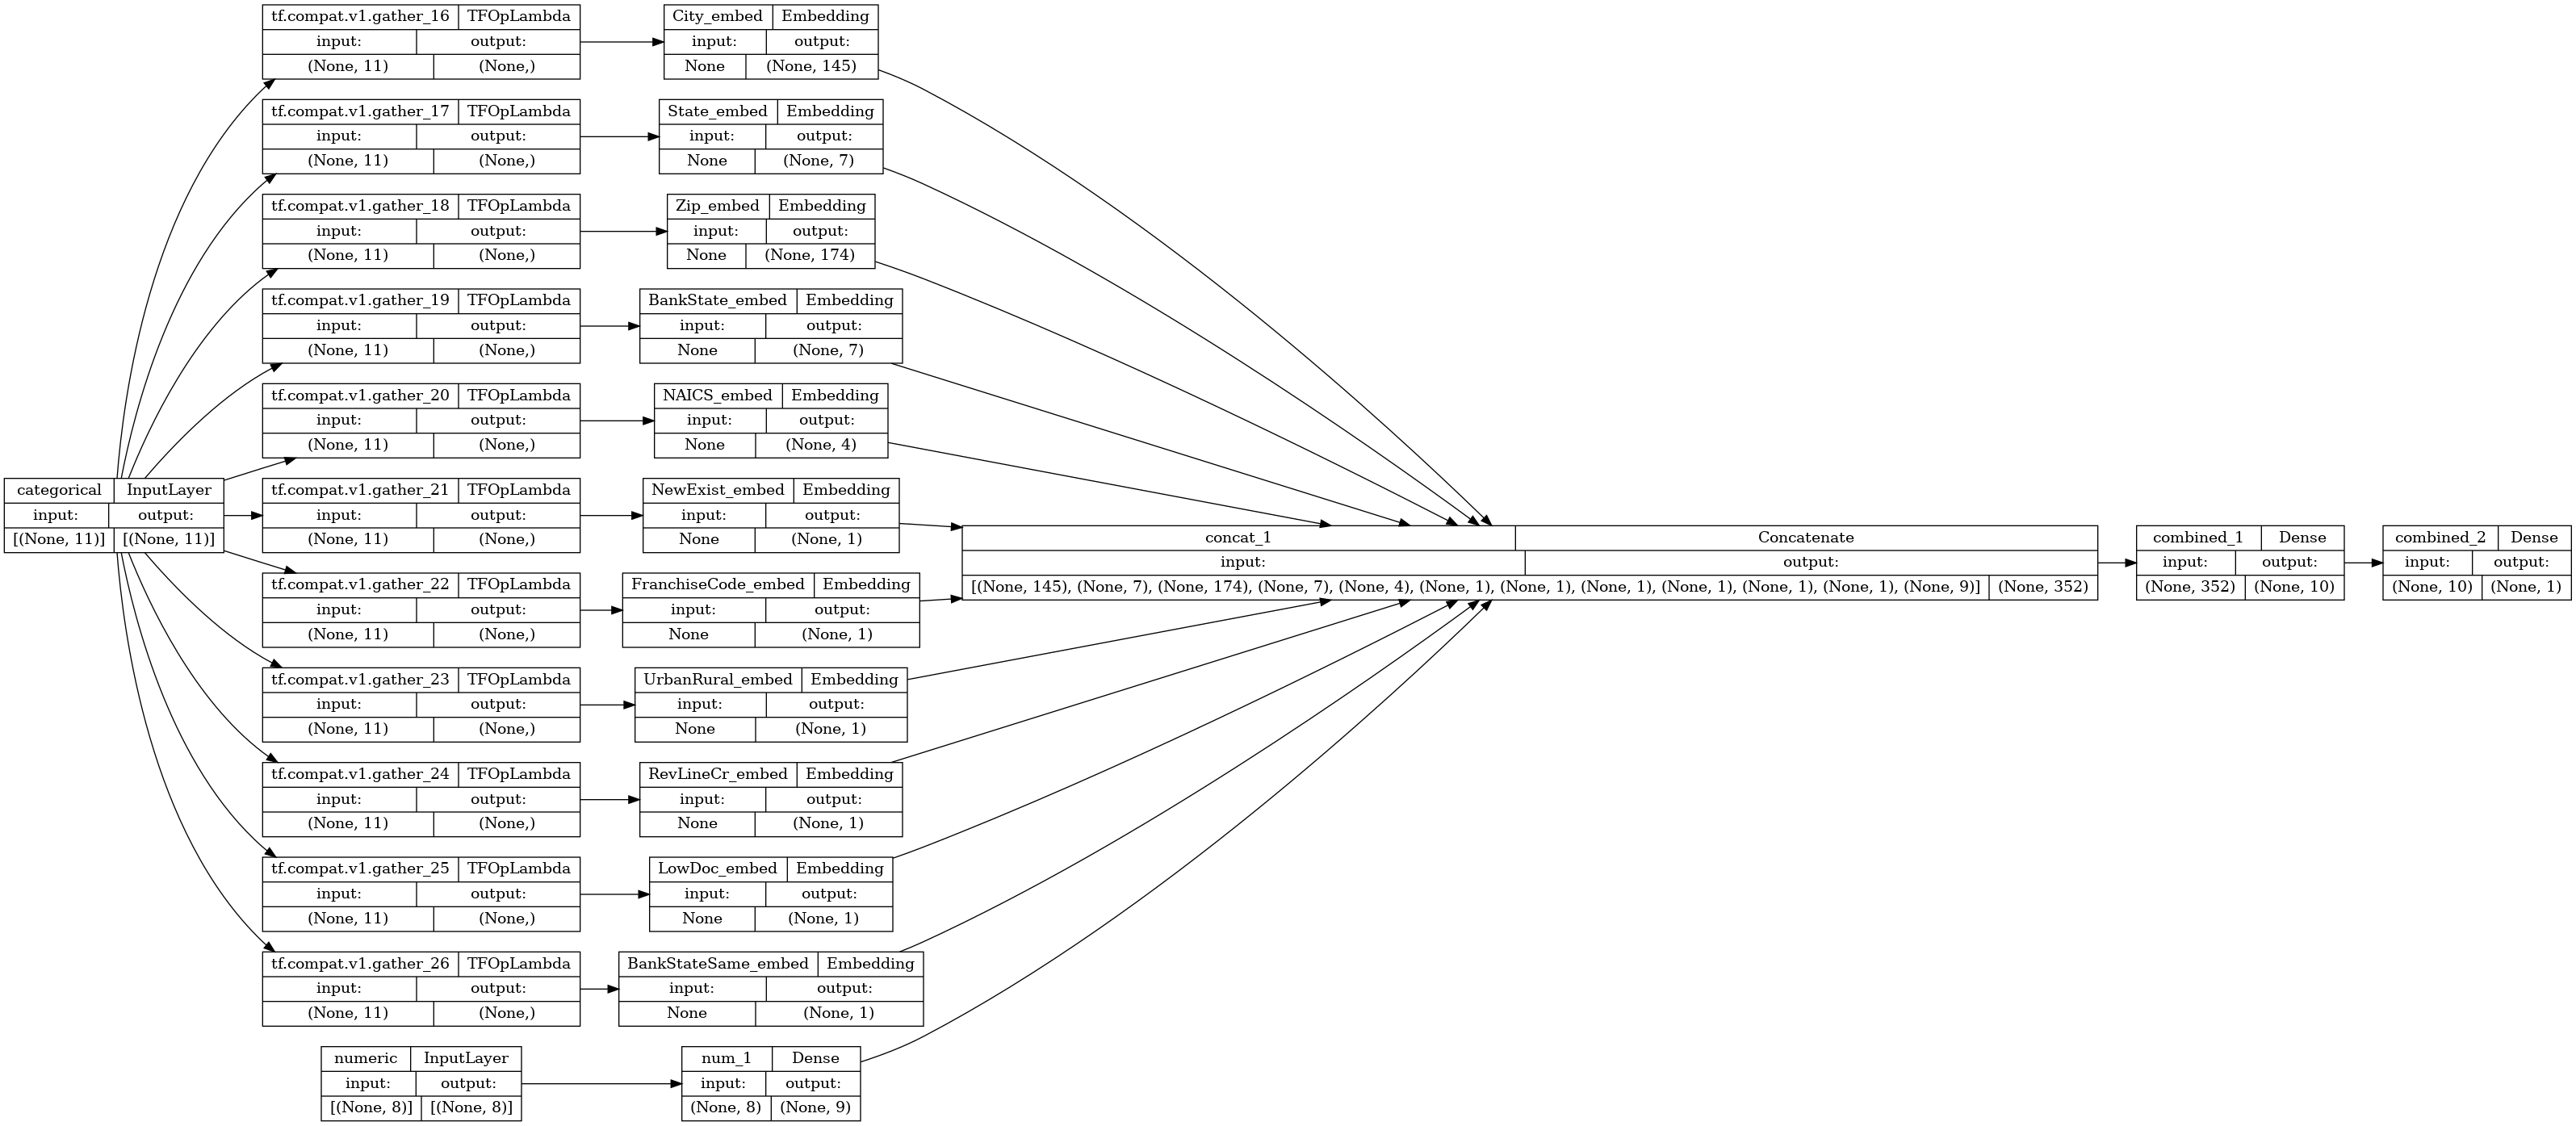

In [20]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [27]:
%%time

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_cat, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=8192, 
          verbose=1)

yhat = model.predict([X_test_cat,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Epoch 1/10
66/66 [==============================] - 2s 20ms/step - loss: 0.0342 - accuracy: 0.9643
Epoch 2/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 3/10
66/66 [==============================] - 1s 17ms/step - loss: 0.0340 - accuracy: 0.9646
Epoch 4/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0340 - accuracy: 0.9646
Epoch 5/10
66/66 [==============================] - 1s 17ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 6/10
66/66 [==============================] - 1s 17ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 7/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 8/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 9/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0339 - accuracy: 0.9647
Epoch 10/10
66/66 [==============================] - 1s 18ms/step - loss: 0.0338 - accuracy: 0.9647
[[ 17591 